## Importing dependencies

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.7 MB/s 
     |████████████████████████████████| 182 kB 61.5 MB/s 
     |████████████████████████████████| 7.6 MB 82.7 MB/s 


In [3]:
#from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, TFTrainer, TFTrainingArguments, DataCollatorWithPadding
from transformers import BertTokenizerFast, TFBertForSequenceClassification, TFTrainer, TFTrainingArguments, DataCollatorWithPadding

import tensorflow as tf
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from matplotlib import pyplot as plt


## Importing data

In [6]:
df = pd.read_csv('df_all.csv')
df.iloc[:,1] = df.iloc[:,1].astype(str)
df = df[['text','class']]
df.head()

,text,class
0,rt crooked hillary you didn't lose because yo...,explicit_hate
1,"rt estonian pm : "" i don't want blacks in es...",explicit_hate
2,are a bunch of religious bigots . i hope you e...,explicit_hate
3,hamas is the only one who lies and all those l...,explicit_hate
4,one of the questions never asked : if africans...,explicit_hate


In [7]:
""" this step is to sample just a fraction of the dataset because 
Google Colab Pro crashed due to out of RAM
"""
df = df.sample(frac = 0.5)

In [8]:
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(32438, 2)
(32438, 2)


In [9]:
df['class'].value_counts()

not_hate         18049
offensive         9600
implicit_hate     3508
explicit_hate     1281
Name: class, dtype: int64

In [10]:
# encoding classes
df['class'] = np.where((df['class'] == 'not_hate'), 0, df['class'])
df['class'] = np.where((df['class'] == 'offensive'), 1, df['class'])
df['class'] = np.where((df['class'] == 'implicit_hate'), 2, df['class'])
df['class'] = np.where((df['class'] == 'explicit_hate'), 3, df['class'])


df.head()

,text,class
4040,if there's going to be an ethnostate we'll ha...,2
14744,: conservatism is liberalism on a long slow bu...,0
40207,WDMC RT @Rhion_R: So what shit is this. Male h...,1
8295,rt #cpac2017 : alt-right denounced w / speech...,0
3416,rachel . i love your sweetness . white women a...,2


The comment with the most words consist of 268 words


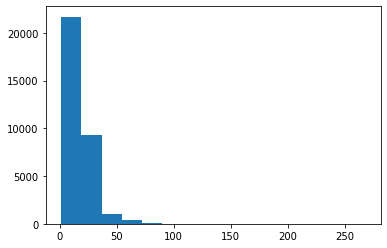

In [11]:
# distribution of number of words

num_words = df['text'].apply(lambda x:len(x.split()))
print('The comment with the most words consist of', num_words.max(),'words')

plt.hist(num_words, bins=15)
plt.show()

## Train Test Split

In [12]:
# Create X  
X=list(df['text']) 

# Create y 
y=list(df['class']) 

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123) 

In [17]:
# https://www.geeksforgeeks.org/python-set-method/
unique_classes=sorted(list(set(y)))
unique_classes

[0, 1, 2, 3]

## Model

In [13]:
# Set up an Object for RobertaTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenize X Train & Test Set 
train_input = tokenizer(X_train, truncation=True, padding=True, return_tensors='tf')
test_input = tokenizer(X_test, truncation=True, padding=True, return_tensors='tf')


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((
                                                    dict(train_input),
                                                    y_train
                                                ))

test_dataset = tf.data.Dataset.from_tensor_slices((
                                                    dict(test_input),
                                                    y_test
                                                ))

In [15]:
training_args = TFTrainingArguments(
                                        output_dir='./results',          
                                        num_train_epochs=3,              
                                        per_device_train_batch_size=8,  
                                        per_device_eval_batch_size=8,   
                                        warmup_steps = 100,
                                        weight_decay=0.01,
                                        logging_steps=10,
                                        eval_steps = 5
                                    )

In [18]:
with training_args.strategy.scope():
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                               num_labels=len(unique_classes))

trainer = TFTrainer(
                    model=model,                         
                    args=training_args,                  
                    train_dataset=train_dataset,         
                    eval_dataset=test_dataset,
                )

trainer.train()

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.8/dist-packages/transformers/trainer_tf.py:115: FutureWarning: The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/main/examples/tensorflow
  warnings.warn(


In [20]:
trainer.save_model('hatespeech_multiclass_BERT')

In [21]:
y_prediction = trainer.predict(test_dataset)[0]
y_prediction = np.argmax(y_prediction, axis = - 1)

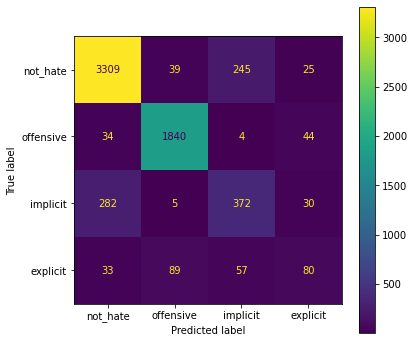

In [26]:
from sklearn import metrics
plt.rcParams['figure.figsize'] = (6, 6)
confusion_matrix = metrics.confusion_matrix(y_test, y_prediction)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ["not_hate", "offensive", "implicit", "explicit" ])

cm_display.plot()

In [27]:
# Accuracy Score 
accuracy = metrics.accuracy_score(y_test, y_prediction)
print('Accuracy: ',accuracy)

# Precision Score Weighted
precision = metrics.precision_score(y_test, y_prediction, average='weighted')
print('Precision: ',precision)

# Recall Score Weighted
recall = metrics.recall_score(y_test, y_prediction, average='weighted')
print('Recall: ',recall)

# F1 Score Weighted
f1 = metrics.f1_score(y_test, y_prediction, average='weighted')
print('F1: ',f1)

Accuracy:  0.8632860665844636
Precision:  0.8568193269173805
Recall:  0.8632860665844636
F1:  0.8594823594774814


In [34]:
df_pred = pd.DataFrame(list(zip(X_test, y_test, y_prediction)),
               columns =['X_test', 'y_test','y_pred'])

df_pred

,X_test,y_test,y_pred
0,It is very clear and stands as it is. If you h...,0,0
1,i'm actually pro-merit . and if white people a...,0,2
2,@44BINKO ima act like I hit that hoe then pass...,1,1
3,can democrats win back the white working class...,0,0
4,RT @ThugLifeIsDead: best twitter beef all time...,1,1
...,...,...,...
6483,"Good morning to you Joe. Wow, what a wave. Hop...",0,0
6484,: u guys need to call out the lies emanating f...,0,0
6485,https://youtu.be/fIRD5NbtfIU,0,0
6486,: that's because laws are for regulating south...,0,0


In [44]:
pd.set_option('display.max_colwidth', 0)
df_pred[(df_pred['y_test']==3) & 
        (df_pred['y_pred']!=3) ][10:20]

,X_test,y_test,y_pred
302,". i'm curious, how is it going through life as a complete retard",3,1
348,black lives are worthless. even atheists know pastors are more important than the average black.,3,2
424,and bring the white hoods and rope !,3,2
431,"Gotta love rednecks. Loud, stupid, stubborn, and full o schitt.",3,1
496,RT @imDOPE_GetHigh: @Whackko man some lame niggah when I find him I'm unfollowing TF out his ass!,3,1
507,"@DefendWallSt Whatever! Fuck all those assholes. They're niggers, they all look alike to me.",3,1
586,oh they love their negroid gods ! they use them to promote black / white race mixing ! might wake a few more whites up !,3,2
598,@_Nadiaxo fags,3,1
628,She got every niggah lookin like dam,3,1
700,Roses be red\nOrchids be bigger \nDonts tell yo daddy\nYou fuckin a nigger \n#VDdie,3,1


In [45]:
pd.set_option('display.max_colwidth', 0)
df_pred[(df_pred['y_test']==2) & 
        (df_pred['y_pred']!=2) ][10:20]

,X_test,y_test,y_pred
242,your statement is utter rubbish . jews killed over 70 million people at the same time ( inclu,2,0
245,youre an idiot plain and simple . white people are a global minority and if demographic change trends continue we will become extreme minorities or disappear completely .,2,0
273,this pope surrenders christianity to islam . jesus said love is the most important . i don't think annih,2,0
296,and there was an underlying white identity resurgence to trump's campaign . it's why the jews freaked so much .,2,0
331,so what's the conspiracy ? jews lied about white people who,2,0
342,"that's joey over there and mary, and jesus and saul and shaquille not that italian, white chick, mexican, jew and black guy",2,0
347,hey u pay ben ben u said that not enough money in israel to pay meso ben and kkk netanyahu away ad min,2,0
353,supremacists of any tilt are stupid black white or whatever . and yes black supremacists exist i just have to watch hidden colours to see .,2,0
395,2 / there is currently an unprecedented assault taking place on the free speech of american citizens by anti-white corporate interests .,2,0
411,cry more corporate america . we'll win with or without you.they ' re scared . extremely scared .,2,0
